# Econometric Analysis

- Loading Oil Price Data
- Downloading idicators dataset

- Understanding the Data

- Data Visualization

Import neccessary libraries and modules

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
# Read the data
# Load data into a pandas DataFrame
price_data = pd.read_csv('../data/data.csv')
price_data['Date'] = pd.to_datetime(price_data['Date'], format='mixed')
price_data.set_index('Date', inplace=True)

### Download Economic Indicators Dataset from World bank

In [ ]:
# Install wbdata
#%pip install wbdata

In [ ]:
import wbdata
import pandas as pd
import os
from datetime import datetime
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def fetch_data(indicator_code, indicator_name, country='WLD', start_date=None, end_date=None):
    """Fetches data from World Bank Data with error handling"""
    try:
        logger.info(f"Fetching {indicator_name} ({indicator_code}) for {country}")
        data = wbdata.get_dataframe(
            {indicator_code: indicator_name},
            country=country,
            data_date=(datetime.strptime(start_date, '%Y-%m-%d'),
                       datetime.strptime(end_date, '%Y-%m-%d'))
        )
        return data
    except Exception as e:
        logger.error(f"Failed to fetch {indicator_code}: {str(e)}")
        return pd.DataFrame()

def clean_data(df, indicator_name):
    """Cleans DataFrame with validation"""
    if df.empty:
        logger.warning("Received empty DataFrame")
        return pd.DataFrame()
    
    try:
        df = df.reset_index().rename(columns={
            'index': 'date',
            df.columns[1]: indicator_name
        })
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date', indicator_name])
        return df
    except Exception as e:
        logger.error(f"Data cleaning failed: {str(e)}")
        return pd.DataFrame()

def resample_data(df, indicator_name, target_freq='D'):
    """Resamples data to target frequency with forward-fill"""
    if df.empty:
        return pd.DataFrame()
    
    df = df.set_index('date')
    try:
        # Resample using appropriate method based on original frequency
        if pd.infer_freq(df.index) in ['A', 'AS']:  # Annual data
            resampled = df.resample('D').ffill()
        else:
            resampled = df.resample(target_freq).interpolate(method='time')
            
        return resampled.reset_index()
    except Exception as e:
        logger.error(f"Resampling failed: {str(e)}")
        return pd.DataFrame()

# Configuration
INDICATORS = {
    'GDP': {'code': 'NY.GDP.MKTP.CD', 'country': 'WLD'},
    'CPI': {'code': 'FP.CPI.TOTL.ZG', 'country': 'WLD'},
    'Unemployment': {'code': 'SL.UEM.TOTL.ZS', 'country': 'WLD'},
    'ExchangeRate': {'code': 'PA.NUS.FCRF', 'country': 'EMU'}
}

DATE_RANGE = ('1987-05-20', '2022-11-14')
OUTPUT_DIR = '../data'

def main():
    # Create output directory if not exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    results = {}
    
    for name, config in INDICATORS.items():
        # Fetch data
        raw_df = fetch_data(
            config['code'],
            name,
            country=config['country'],
            start_date=DATE_RANGE[0],
            end_date=DATE_RANGE[1]
        )
        
        # Clean and process
        clean_df = clean_data(raw_df, name)
        if not clean_df.empty:
            resampled_df = resample_data(clean_df, name)
            
            # Save to CSV
            if not resampled_df.empty:
                file_path = os.path.join(OUTPUT_DIR, f"{name}_daily.csv")
                resampled_df.to_csv(file_path, index=False)
                logger.info(f"Saved {name} data to {file_path}")
                results[name] = resampled_df
        else:
            logger.warning(f"No data available for {name}")
    
    return results

if __name__ == '__main__':
    data_results = main()
    logger.info("Data processing completed. Available datasets:")
    for name, df in data_results.items():
        logger.info(f"{name}: {len(df)} records")

Investigate relationships between econometric indicators and oil prices


Correlation between GDP and oil prices: 0.756300978597202


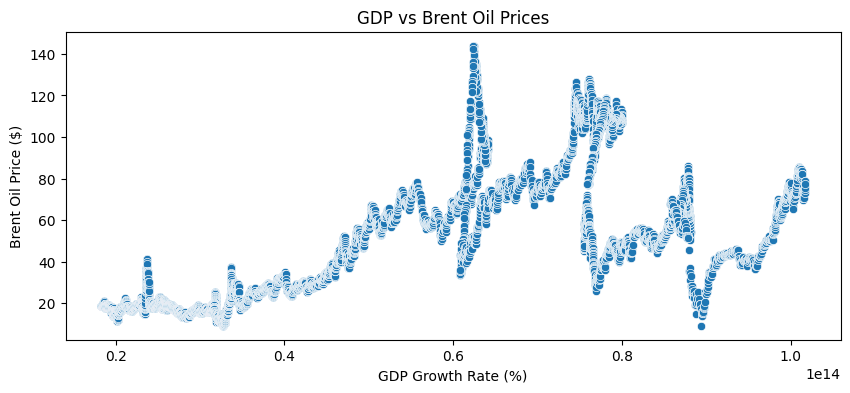

Correlation between CPI and oil prices: -0.4095557412930654


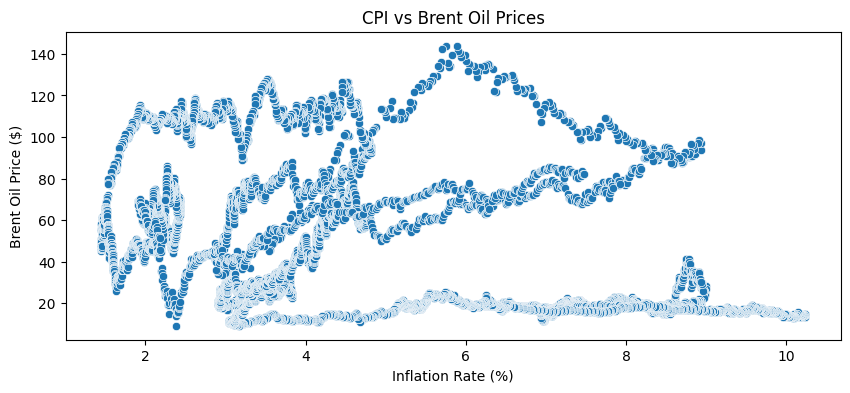

Correlation between Unemployment Rate and oil prices: 0.0446983999376375


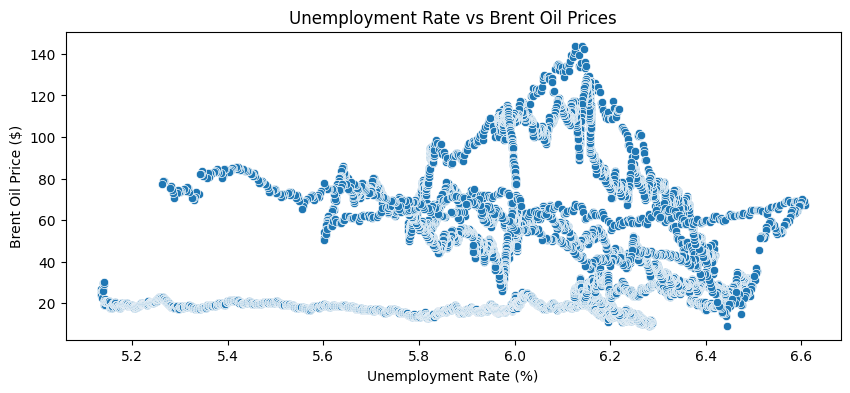

Correlation between Exchange Rate and oil prices: -0.6736337150209103


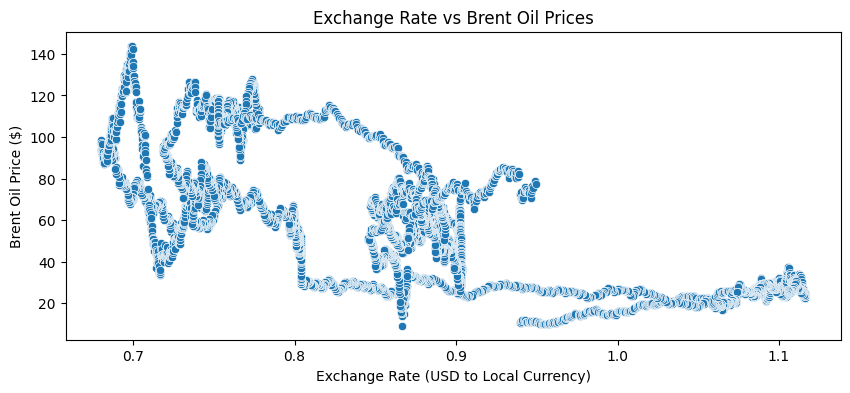

In [4]:
def analyze_indicators(gdp_data, inflation_data, unemployment_data, exchange_rate_data, oil_data):
    """
    Analyzes the correlation between economic indicators and oil prices,
    and generates scatter plots for each indicator.
    
    Parameters:
    gdp_data (DataFrame): Daily GDP data with columns ['Date', 'GDP'].
    inflation_data (DataFrame): Daily inflation data with columns ['Date', 'CPI'].
    unemployment_data (DataFrame): Daily unemployment data with columns ['Date', 'Unemployment Rate'].
    exchange_rate_data (DataFrame): Daily exchange rate data with columns ['Date', 'Exchange Rate'].
    oil_data (DataFrame): Daily oil price data with columns ['Date', 'Price'].
    """
    
    # Function to merge and analyze
    def analyze_and_plot(indicator_data, indicator_name, oil_data, x_label):
        merged_data = pd.merge(indicator_data, oil_data.reset_index(), on='Date')
        
        # Drop NaN values to ensure correlation calculation is valid
        merged_data.dropna(inplace=True)
        correlation = merged_data[indicator_name].corr(merged_data['Price'])
        print(f"Correlation between {indicator_name} and oil prices: {correlation}")

        # Scatter plot
        plt.figure(figsize=(10, 4))
        sns.scatterplot(data=merged_data, x=indicator_name, y='Price')
        plt.title(f'{indicator_name} vs Brent Oil Prices')
        plt.xlabel(x_label)
        plt.ylabel('Brent Oil Price ($)')
        plt.show()

    # Analyze GDP
    analyze_and_plot(gdp_data, 'GDP', oil_data, 'GDP Growth Rate (%)')

    # Analyze Inflation
    analyze_and_plot(inflation_data, 'CPI', oil_data, 'Inflation Rate (%)')

    # Analyze Unemployment
    analyze_and_plot(unemployment_data, 'Unemployment Rate', oil_data, 'Unemployment Rate (%)')

    # Analyze Exchange Rate
    analyze_and_plot(exchange_rate_data, 'Exchange Rate', oil_data, 'Exchange Rate (USD to Local Currency)')

# Example of calling the function
# Ensure you have the cleaned daily data for each indicator ready
# gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, and price_data_daily
analyze_indicators(gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, price_data)


In [5]:
# gdp_data_daily, exchange_rate_data_daily they have strong correlation with price
# Merge all datasets on 'Date' column
merged_data = (
    gdp_data_daily
    .merge(exchange_rate_data_daily, on='Date', how='outer')
    .merge(price_data.reset_index(), on='Date', how='outer')
)

# Fill missing values with forward fill for consistency if there are any gaps
merged_data.ffill(inplace=True)

# Save to csv file
merged_data.to_csv('../data/features.csv', index=False)